# Fast Training of Support Vector Machines for Survival Analysis

This document demonstrates how to use the efficient implementation of *Survival Support Vector Machines* as proposed in

> Pölsterl, S., Navab, N., and Katouzian, A.,
> *Fast Training of Support Vector Machines for Survival Analysis*,
> Machine Learning and Knowledge Discovery in Databases: European Conference,
> ECML PKDD 2015, Porto, Portugal,
> Lecture Notes in Computer Science, vol. 9285, pp. 243-259 (2015)

The source code and installation instructions are available at https://github.com/sebp/scikit-survival.

The main class of interest is ``sksurv.svm.FastSurvivalSVM``, which implements the different optimizers for training
a Survival Support Vector Machine. Training data consists of $n$ triplets $(\mathbf{x}_i, y_i, \delta_i)$, where
$\mathbf{x}_i$ is a $d$-dimensional feature vector, $y_i > 0$ the survival time or time of censoring, and $\delta_i \in \{0,1\}$ the binary event indicator. Using the training data, the objective is to minimize the following function:

\begin{equation}
 \arg \min_{\mathbf{w}, b} \frac{1}{2} \mathbf{w}^T \mathbf{w}+ \frac{\alpha}{2} \left[
 r \sum_{i,j \in \mathcal{P}}
  \max(0, 1 - (\mathbf{w}^T \mathbf{x}_i - \mathbf{w}^T \mathbf{x}_j))^2
+ (1 - r) \sum_{i=0}^n \left( \zeta_{\mathbf{w},b} (y_i, x_i, \delta_i) \right)^2
\right]
\end{equation}

\begin{equation}
\zeta_{\mathbf{w},b} (y_i, \mathbf{x}_i, \delta_i) =
\begin{cases}
  \max(0, y_i - \mathbf{w}^T \mathbf{x}_i - b) & \text{if $\delta_i = 0$,} \\
 y_i - \mathbf{w}^T \mathbf{x}_i - b & \text{if $\delta_i = 1$,} \\
\end{cases}
\end{equation}

\begin{equation}
\mathcal{P} = \{ (i, j)~|~y_i > y_j \land \delta_j = 1 \}_{i,j=1,\dots,n}
\end{equation}

The hyper-parameter $\alpha > 0$ determines the amount of regularization to apply: a smaller value increases the amount of regularization and a higher value reduces the amount of regularization. The hyper-parameter $r \in [0; 1]$ determines the trade-off between the ranking objective and the regresson objective. If $r = 1$ it reduces to the ranking objective, and if $r = 0$ to the regression objective. If the regression objective is used, it is advised to log-transform the survival/censoring time first.

In this example, I'm going to use the ranking objective ($r = 1$) and grid search to determine the best setting for the hyper-parameter $\alpha$.

The class ``sksurv.svm.FastSurvivalSVM`` adheres to interfaces used in [scikit-learn](http://scikit-learn.org) and thus it is possible to combine it with auxiliary classes and functions from scikit-learn. Here, I'm going to use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.module_selection.GridSearchCV.html) to determine which set hyper-parameters performs best for the Veteran's Lung Cancer data. Since, we require an event indicator $\delta_i$, which is boolean, and the survival/censoring time $y_i$ for training, we have to create a structured array that contains both information.

But first, we have to import the classes we are going to use.

本文档演示了如何使用生存支持向量机的有效实现

Polsterl, S。布,N。，和Katouzian, A。《支持向量机在数据库中生存分析、机器学习和知识发现的快速训练:欧洲会议，ECML PKDD 2015，葡萄牙波尔图，计算机科学讲义》，第9285卷，第243-259页(2015)

源代码和安装说明可以在https://github.com/sebp/scikit-survival找到。

主要感兴趣的类是sksurv.svm。fastsurvival valsvm，实现了不同的优化训练生存支持向量机。

主要感兴趣的类是sksurv.svm。fastsurvival valsvm，实现了不同的优化训练生存支持向量机。训练数据由n三胞胎(xi,yi,δi) 其中xi是d维特征向量,yi> 0的生存时间或审查,和δi∈{0,1}δi∈{0,1}二进制事件指标。利用训练数据，目标是最小化以下功能:
argminw,b12wTw+α2[r∑i,j∈max(0,1−(wTxi−wTxj))2+(1−r)∑i=0n(ζw,b(yi,xi,δi))2]

ζw,b(yi,xi,δi)={max(0,yi−wTxi−b)if δi=0,yi−wTxi−bif δi=1,
 
P={(i,j) | yi>yj∧δj=1}i,j=1,…,n

hyper-parameterα> 0α> 0确定正则化应用的数量:一个更小的值增加的正规化和更高的价值减少的正规化。超参数r∈[0;1]r∈[0;1]决定了排序目标与回归目标之间的取舍。如果r=1r=1，则归为排序目标，如果r=0r=0，则归为回归目标。如果使用回归目标，建议先对生存/截尾时间进行对数变换。
在这个例子中,我将使用排名目标(r = 1 = 1)和网格搜索来确定最佳设置hyper-parameterαα。

类sksurv.svm。fastlivevalsvm坚持使用scikit-learn中的接口，因此可以将它与scikit-learn中的辅助类和函数相结合。在这里，我将使用GridSearchCV来确定哪个超参数集最适合退伍军人的肺癌数据。以后,我们需要一个事件指标δiδi,布尔,依依和生存/审查时间训练,我们必须创建一个结构数组,其中包含两个信息。

但是首先，我们必须导入将要使用的类。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical  #编码
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

Next, load data of the *Veteran's Administration Lung Cancer Trial* from disk and convert it to numeric values. The data consists of 137 patients and 6 features. The  primary  outcome  measure  was  death (`Status`, `Survival_in_days`).
The original data can be retrieved from http://lib.stat.cmu.edu/datasets/veteran.

Note that it does not matter how you name the fields corresponding to the event indicator and time, as long as the event indicator comes first.

接下来，从磁盘加载退伍军人管理局肺癌试验的数据并将其转换为数值。资料包括137个病人和6个特征。主要的结果测量是死亡(状态，生存天数)。可以从http://lib.stat.cmu.edu/datasets/veteran检索原始数据。
请注意，如何命名与事件指示器和时间对应的字段并不重要，只要先出现事件指示器即可。

In [3]:
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

Now, we are essentially ready to start training, but before let's determine what the amount of censoring for this data is and plot the survival/censoring times.

现在，我们基本上已经准备好开始训练了，但是在我们确定这个数据的审查量和绘制生存/审查时间之前。

In [4]:
n_censored = y.shape[0] - y["Status"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

6.6% of records are censored


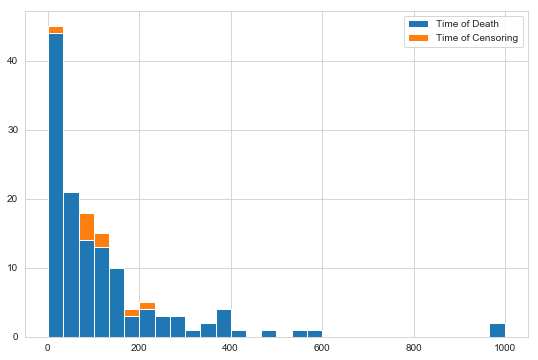

In [5]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y["Survival_in_days"][y["Status"]],
                               y["Survival_in_days"][~y["Status"]]),
                              bins=30, stacked=True)
plt.legend(patches, ["Time of Death", "Time of Censoring"])

First, we need to create an initial model with default parameters that is subsequently used in the grid search. We are going to use a Red-Black tree to speed up optimization.

首先，我们需要创建一个带有默认参数的初始模型，随后在网格搜索中使用这些参数。我们将使用红黑树来加速优化。

In [6]:
estimator = FastSurvivalSVM(optimizer="rbtree", max_iter=1000, tol=1e-6, random_state=0)

Next, we define a function for evaluating the performance of models during grid search. We use Harrell's concordance index.

接下来，我们定义一个函数来评估网格搜索过程中模型的性能。我们使用哈勒尔索引。

In [7]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]

The last part of the setup specifies the set of parameters we want to try and how many repetitions of training and testing we want to perform for each parameter setting. In the end, the parameters that on average peformed best across all test sets (200 in this case) are selected. [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) can leverage multiple cores by evaluating multiple parameter settings concurrently (I use 4 jobs in this example).

设置的最后一部分指定了我们想要尝试的参数集，以及我们想要为每个参数设置执行多少次重复的训练和测试。最后，选择平均在所有测试集(本例中为200)中表现最好的参数。GridSearchCV可以通过同时评估多个参数设置来利用多个核心(在本例中我使用了4个作业)。

In [8]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=200, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=4, iid=False, refit=False,
                   cv=cv)

In [9]:
param_grid

{'alpha': array([2.44140625e-04, 9.76562500e-04, 3.90625000e-03, 1.56250000e-02,
        6.25000000e-02, 2.50000000e-01, 1.00000000e+00, 4.00000000e+00,
        1.60000000e+01, 6.40000000e+01, 2.56000000e+02, 1.02400000e+03,
        4.09600000e+03])}

Finally, start the hyper-parameter search. This can take a while since a total of ``13 * 200 = 2600`` fits have to be evaluated.

最后，开始超参数搜索。这可能需要一段时间，因为总共需要评估13 * 200 = 2600个点。

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x, y)

Let's check what is the best average performance across 200 random train/test splits we got and the corresponding hyper-parameters.

让我们检查一下在200个随机的火车/测试分割中我们得到的最佳平均性能以及相应的超参数。

In [11]:
gcv.best_score_, gcv.best_params_

(0.718221596570157, {'alpha': 0.00390625})

Finally, we retrieve all 200 test scores for each parameter setting and visualize their distribution by box plots.

最后，我们检索每个参数设置的所有200个测试分数，并通过框图可视化它们的分布。

In [12]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):            
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

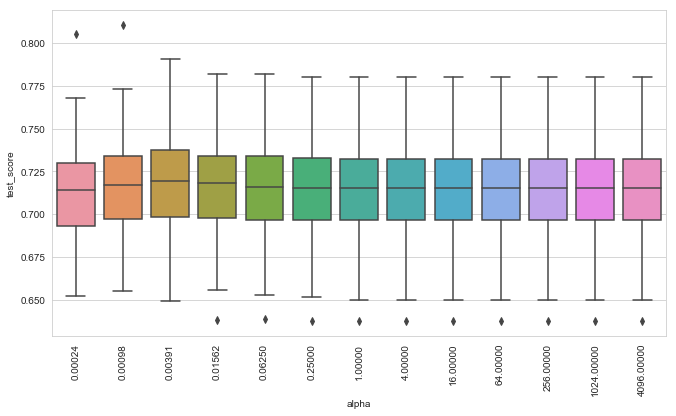

In [13]:
plot_performance(gcv)

# Kernel Survival Support Vector Machine

This section demonstrates how to use the efficient implementation of *Kernel Survival Support Vector Machines* as proposed in

> Pölsterl, S., Navab, N., and Katouzian, A.,
> *An Efficient Training Algorithm for Kernel Survival Support Vector Machines*
> 4th Workshop on Machine Learning in Life Sciences,
> 23 September 2016, Riva del Garda, Italy

As kernel we are going to use the clinical kernel, because it distinguishes between continuous, ordinal, and nominal attributes.

## 内核生存支持向量机
本节演示如何使用内核生存支持向量机的有效实现
> Polsterl, S。布,N。，和Katouzian, A。
> *一种高效的核生存支持向量机训练算法*
> 第4届生命科学机器学习研讨会,
> 2016年9月23日，意大利Riva del Garda

作为核心，我们将使用临床核心，因为它区分连续、顺序和名义属性。


In [14]:
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel

To use `GridSearchCV` with a custom kernel, we need to pre-compute the squared kernel matrix and pass it to `GridSearchCV.fit` later. It would also be possible to construct `FastKernelSurvivalSVM` with `kernel="rbf"` (or any other built-in kernel), which does not require pre-computing the kernel matrix.

要使用带有自定义内核的GridSearchCV，我们需要预先计算平方内核矩阵并将其传递给GridSearchCV。适合后。也可以使用kernel="rbf"(或任何其他内置的内核)来构造fastkernel生存svm，它不需要预先计算内核矩阵。

In [15]:
kernel_matrix = clinical_kernel(data_x)
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

In [16]:
kgcv = GridSearchCV(kssvm, param_grid, score_survival_model,
                    n_jobs=4, iid=False, refit=False,
                    cv=cv)

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
kgcv = kgcv.fit(kernel_matrix, y)

Now, print the best average concordance index the corresponding parameters.

现在，打印出最佳平均索引的相应参数。

In [18]:
kgcv.best_score_, kgcv.best_params_

(0.7071426137273039, {'alpha': 0.015625})

Finally, we visualize the distribution of test scores obtained via cross-validation.

最后，我们将通过交叉验证得到的测试分数分布可视化。

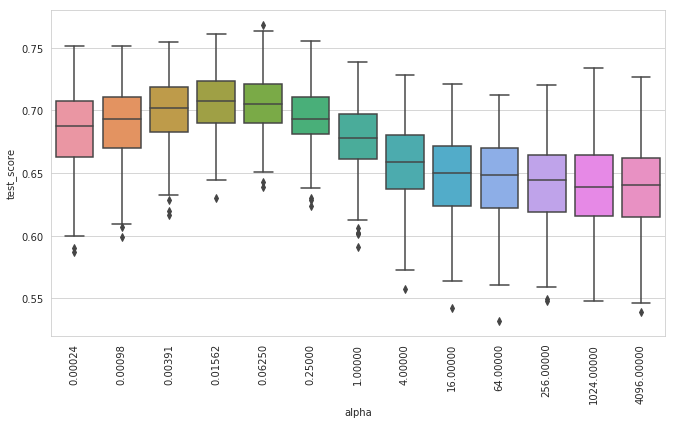

In [19]:
plot_performance(kgcv)

## On the use of a clinical kernel in survival analysis
## 临床核心在生存分析中的应用

临床数据集通常包含连续的、有序的、分类的和二元的变量。为了对这类数据集进行建模，通常使用线性核方法。然而，线性核有一些缺点，这是通过介绍一个临床的。这一工作表明，临床内核的使用可以提高支持向量机生存模型的性能。此外，以同样的方式调整多项式核以获得临床多项式核。对六种不同的生存数据与其他非线性加性核进行了比较。我们的结果表明，临床内核的使用是获得用于生存分析的非线性模型的一种简单方法，不需要调整额外的参数。

https://ieeexplore.ieee.org/document/5334847/citations#citations

## 独热码
在英文文献中称做 one-hot code, 直观来说就是有多少个状态就有多少比特，而且只有一个比特为1，其他全为0的一种码制。举例如下：

假如有三种颜色特征：红、黄、蓝。 在利用机器学习的算法时一般需要进行向量化或者数字化。那么你可能想令 红=1，黄=2，蓝=3. 那么这样其实实现了标签编码，即给不同类别以标签。然而这意味着机器可能会学习到“红<黄<蓝”，但这并不是我们的让机器学习的本意，只是想让机器区分它们，并无大小比较之意。所以这时标签编码是不够的，需要进一步转换。因为有三种颜色状态，所以就有3个比特。即红色：1 0 0 ，黄色: 0 1 0，蓝色：0 0 1 。如此一来每两个向量之间的距离都是根号2，在向量空间距离都相等，所以这样不会出现偏序性，基本不会影响基于向量空间度量算法的效果。

 正如上文所言，独热编码（哑变量 dummy variable）是因为大部分算法是基于向量空间中的度量来进行计算的，为了使非偏序关系的变量取值不具有偏序性，并且到圆点是等距的。使用one-hot编码，将离散特征的取值扩展到了欧式空间，离散特征的某个取值就对应欧式空间的某个点。将离散型特征使用one-hot编码，会让特征之间的距离计算更加合理。离散特征进行one-hot编码后，编码后的特征，其实每一维度的特征都可以看做是连续的特征。就可以跟对连续型特征的归一化方法一样，对每一维特征进行归一化。比如归一化到[-1,1]或归一化到均值为0,方差为1。       

        为什么特征向量要映射到欧式空间？

        将离散特征通过one-hot编码映射到欧式空间，是因为，在回归，分类，聚类等机器学习算法中，特征之间距离的计算或相似度的计算是非常重要的，而我们常用的距离或相似度的计算都是在欧式空间的相似度计算，计算余弦相似性，基于的就是欧式空间。
        
独热编码优缺点

优点：独热编码解决了分类器不好处理属性数据的问题，在一定程度上也起到了扩充特征的作用。它的值只有0和1，不同的类型存储在垂直的空间。
缺点：当类别的数量很多时，特征空间会变得非常大。在这种情况下，一般可以用PCA来减少维度。而且one hot encoding+PCA这种组合在实际中也非常有用。

In [18]:
from sksurv.preprocessing import OneHotEncoder
x_ = OneHotEncoder().fit_transform(data_x)
x_

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0
5,49.0,0.0,0.0,1.0,20.0,5.0,0.0,0.0
6,69.0,0.0,0.0,1.0,40.0,10.0,1.0,0.0
7,68.0,0.0,0.0,1.0,80.0,29.0,0.0,0.0
8,43.0,0.0,0.0,1.0,50.0,18.0,0.0,0.0
9,70.0,0.0,0.0,1.0,70.0,6.0,0.0,0.0


In [21]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
5,49.0,squamous,20.0,5.0,no,standard
6,69.0,squamous,40.0,10.0,yes,standard
7,68.0,squamous,80.0,29.0,no,standard
8,43.0,squamous,50.0,18.0,no,standard
9,70.0,squamous,70.0,6.0,no,standard


In [22]:
#　编码
x = encode_categorical(data_x)
x

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0
5,49.0,0.0,0.0,1.0,20.0,5.0,0.0,0.0
6,69.0,0.0,0.0,1.0,40.0,10.0,1.0,0.0
7,68.0,0.0,0.0,1.0,80.0,29.0,0.0,0.0
8,43.0,0.0,0.0,1.0,50.0,18.0,0.0,0.0
9,70.0,0.0,0.0,1.0,70.0,6.0,0.0,0.0
